In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import timezone, datetime,date
import pytz
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge,LogisticRegression
from sklearn import metrics

pac = pytz.timezone('America/Los_Angeles')
utc = pytz.timezone('UTC')
%matplotlib inline


In [2]:
MthOrder = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [3]:
df_rain = pd.read_csv('./data/seattleWeather_1948-2017.csv',index_col="DATE", parse_dates=['DATE'])

print('rain data from {} to {}'.format(df_rain.index.min(),df_rain.index.max()))
# print('Rain date from {}').format('test')

rain data from 1948-01-01 00:00:00 to 2017-12-14 00:00:00


In [4]:
#this will be our predict y
df_rain['RAIN'] = df_rain['RAIN'].astype('bool')

In [5]:
#create field to resample all data to one year
df_rain['month'] = df_rain.index.strftime("%m")
df_rain["month"] = df_rain["month"].astype(str).astype(int)

df_rain['day'] = df_rain.index.strftime("%d")
df_rain["day"] = df_rain["day"].astype(str).astype(int)

df_rain['day_of_year'] = df_rain.index.strftime("%j")
df_rain["day_of_year"] = df_rain["day_of_year"].astype(str).astype(int)

df_rain['date_group']=df_rain.index.strftime("%m-%d-2020") #has to be a leapyear
df_rain['date_group']=pd.to_datetime(df_rain['date_group'])


In [6]:
df_rain.dtypes

PRCP                  float64
TMAX                    int64
TMIN                    int64
RAIN                     bool
month                   int32
day                     int32
day_of_year             int32
date_group     datetime64[ns]
dtype: object

''

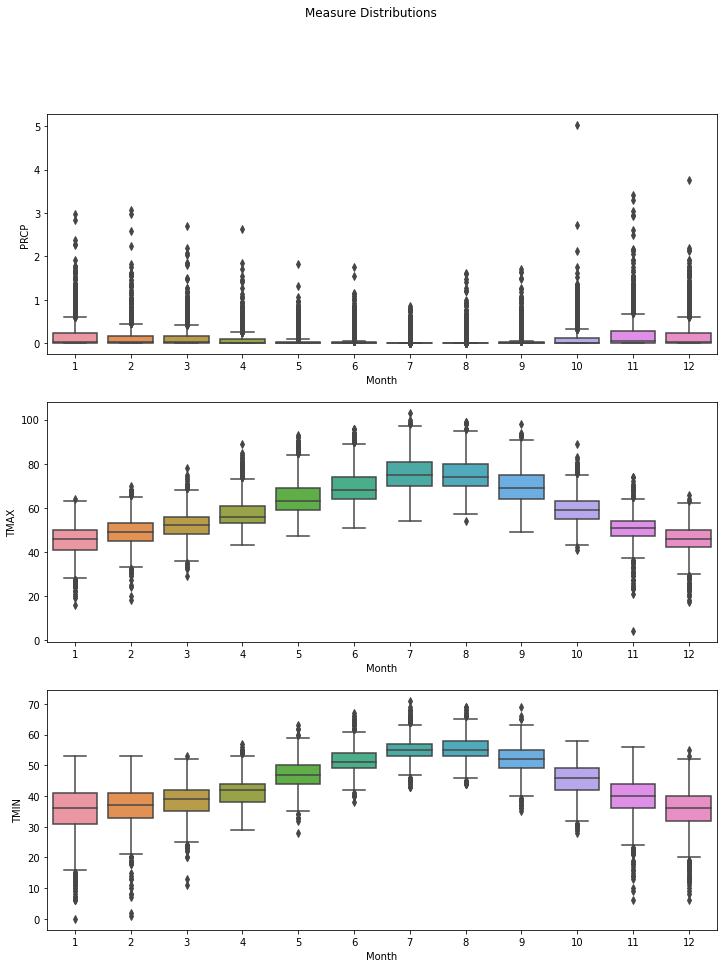

In [7]:
with plt.rc_context({'xtick.color':'black', 'ytick.color':'black'}):
    fig, (ax1,ax2,ax3) = plt.subplots(nrows= 3, ncols =1 ,figsize=(12,15))
    
    sns.boxplot(x=df_rain.index.month,y=df_rain['PRCP'],data= df_rain, ax=ax1,showfliers=True)
    sns.boxplot(x=df_rain.index.month,y=df_rain['TMAX'],data= df_rain, ax=ax2,showfliers=True)
    sns.boxplot(x=df_rain.index.month,y=df_rain['TMIN'],data= df_rain, ax=ax3,showfliers=True)
    
ax1.set_xlabel('Month')
ax2.set_xlabel('Month')
ax3.set_xlabel('Month')
    
fig.suptitle('Measure Distributions')
;

In [8]:
df_rain_month_sum = df_rain.groupby(['date_group']).sum()
df_rain_month_mean = df_rain.groupby(['date_group']).mean()

In [9]:
df_rain_month_mean = pd.pivot_table(df_rain_month_mean
                                      , index=df_rain_month_mean.index.day
                                      , columns=df_rain_month_mean.index.strftime('%b')
                                      , values="PRCP"
                                      )

In [10]:
#correct sort to display in heatmap
df_rain_month_mean.sort_index(level=0, ascending=False, inplace=True)
df_rain_month_mean = df_rain_month_mean.reindex(columns=MthOrder)

In [11]:
df_rain_month_sum = pd.pivot_table(df_rain_month_sum
                                      , index=df_rain_month_sum.index.day
                                      , columns=df_rain_month_sum.index.strftime('%b')
                                      , values="PRCP"
                                      )

In [12]:
#correct sort to display in heatmap
df_rain_month_sum.sort_index(level=0, ascending=False, inplace=True)
df_rain_month_sum = df_rain_month_sum.reindex(columns=MthOrder)

''

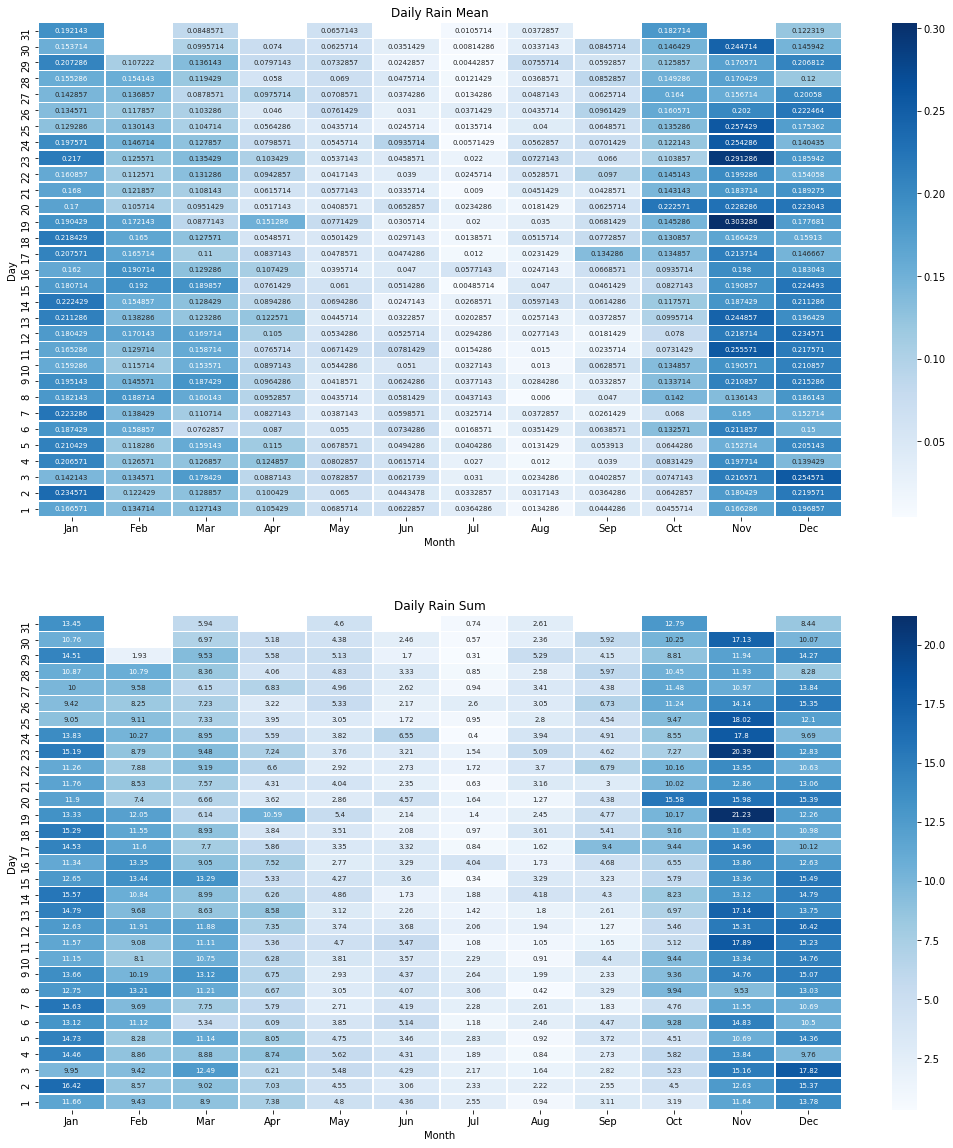

In [13]:
fig, (ax,ax2) = plt.subplots(nrows=2, ncols=1, figsize=[18, 20])
sns.heatmap(df_rain_month_mean,
            annot=True,
            annot_kws={"size": 7},
            fmt="g",
            linewidths=.5,
            cbar=True,
            cmap="Blues",
            ax=ax)

sns.heatmap(df_rain_month_sum,
            annot=True,
            annot_kws={"size": 7},
            fmt="g",
            linewidths=.5,
            cbar=True,
            cmap="Blues",
            ax=ax2)




ax.set_title('Daily Rain Mean')
ax.set_xlabel('Month')
ax.set_ylabel('Day')
ax2.set_title('Daily Rain Sum')
ax2.set_xlabel('Month')
ax2.set_ylabel('Day')
;

In [14]:
binary = pd.DataFrame(df_rain[['RAIN','PRCP']].groupby(['RAIN']).agg(['sum','count']))
binary

PRCP       
           sum  count
RAIN                 
False     0.00  14648
True   2713.75  10900

In [15]:
model_data = df_rain[['TMAX','TMIN','RAIN','day_of_year']]

In [16]:
model_data.head()

,TMAX,TMIN,RAIN,day_of_year
DATE,,,,
1948-01-01,51,42,True,1
1948-01-02,45,36,True,2
1948-01-03,45,35,True,3
1948-01-04,45,34,True,4
1948-01-05,45,32,True,5


In [17]:
model_data = pd.get_dummies(data=model_data,columns=['day_of_year'],dtype=bool)
# model_df = pd.DataFrame(pd.get_dummies(data=df_rain,columns=['month','day']))

In [18]:
# plt.rcParams['figure.figsize'] = (20, 20)
# corr = model_data.corr()
# ax = sns.heatmap(
#     corr, 
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );

In [19]:
features = [i for i in list(model_data.columns) if i != 'RAIN']

In [20]:
X = model_data[features]
y = model_data['RAIN']




In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state= 23)

y_baseline = [False] * len(y_test)


print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(19163, 368)
(19163,)
(6388, 368)
(6388,)


In [22]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

model_score = model.score(X_test, y_test)
baseline_score = metrics.accuracy_score(y_true = y_test,y_pred=y_baseline)

# print("Accuracy = ",model_score)

In [23]:
cm_baseline = metrics.confusion_matrix(y_test, y_baseline)

In [24]:
cm_model = metrics.confusion_matrix(y_test, y_pred)


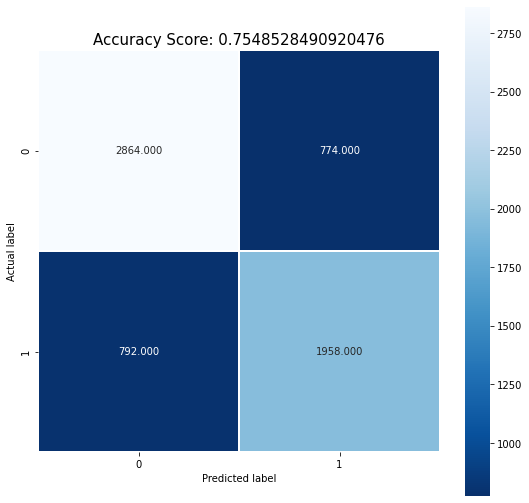

In [25]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_model, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(model_score)
plt.title(all_sample_title, size = 15);

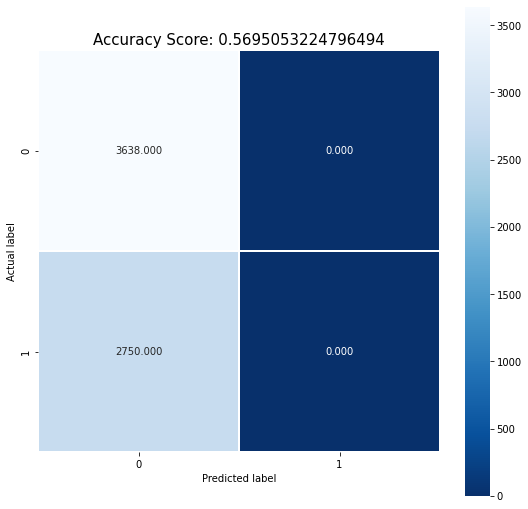

In [26]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_baseline, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(baseline_score)
plt.title(all_sample_title, size = 15);